In [1]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
# !pip install git+https://github.com/tensorflow/docs

In [4]:
pip install tensorflow tensorflow-datasets


  Obtaining dependency information for tensorflow-datasets from https://files.pythonhosted.org/packages/8f/50/52fa3d41d20c687d81f66338bc1b0e71a27a3390ecfa8f5bc212a10135e1/tensorflow_datasets-4.9.6-py3-none-any.whl.metadata
  Obtaining dependency information for immutabledict from https://files.pythonhosted.org/packages/e2/13/3cf4ac5b3403f3456e645c4533883ef67b1bb0c72e56b79c707715f57a74/immutabledict-4.2.0-py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for simple-parsing from https://files.pythonhosted.org/packages/b0/12/c657047c11a47e1c3e51bdc26bd6f2661a268fd0384bd8ed56b227530486/simple_parsing-0.1.5-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow-metadata from https://files.pythonhosted.org/packages/aa/47/91d1eea615b12473853edcbc0db02c94918e498bdf36049dde13bf24100d/tensorflow_metadata-1.15.0-py3-none-any.whl.metadata
  Obtaining dependency info

In [3]:
pip install opencv-python


  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/76/9e/4d47a69d3338a00c51535028d25a7d1a17c4762e4a46ae6a577f495de252/opencv_python-4.10.0.82-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.8 MB 1.0 MB/s eta 0:00:38
   ---------------------------------------- 0.3/38.8 MB 1.3 MB/s eta 0:00:30
   ---------------------------------------- 0.3/38.8 MB 1.5 MB/s eta 0:00:26
   ---------------------------------------- 0.5/38.8 MB 1.7 MB/s eta 0:00:24
    --------------------------------------- 0.6/38.8 MB 1.8 MB/s eta 0:00:22
    --------------------------------------- 0.7/38.8 MB 1.8 MB/s eta 0:00:21
    --------------------------------------- 0.8/38.8 MB 1.9 MB/s eta 0:00:20
    -------------------------

In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import time
import tensorflow_probability as tfp


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm

# Set the paths to the dataset
data_dir = 'archive'  # Update this path
img_dir = os.path.join(data_dir, 'img_align_celeba/img_align_celeba')
bbox_file = os.path.join(data_dir, 'list_bbox_celeba.csv')

# Load bounding box information from the Excel file
bbox_data = pd.read_csv(bbox_file)

# Function to preprocess and crop the images
def preprocess_and_crop(image_path, bbox):
    img = cv2.imread(image_path)
    resized_img = cv2.resize(img, (28, 28))  # Resize to 128x128
    normalized_img = resized_img / 255.0  # Normalize to [0, 1] range
    return normalized_img

# Placeholder for preprocessed images
preprocessed_images = []

# Process each image
for i in tqdm(range(len(bbox_data))):
    if (i==50000):
        break
    img_filename = bbox_data.iloc[i, 0]
    img_path = os.path.join(img_dir, img_filename)
    bbox = bbox_data.iloc[i, 1:].values
    preprocessed_img = preprocess_and_crop(img_path, bbox)
    if preprocessed_img is not None:
        preprocessed_images.append(preprocessed_img)


 25%|██████████████████▎                                                       | 50000/202599 [01:51<05:38, 450.40it/s]


In [3]:

# Convert to numpy array for model input
preprocessed_images = np.array(preprocessed_images, dtype=np.float32)


# Display the shape of the dataset
print(preprocessed_images.shape)

(50000, 28, 28, 3)


In [4]:
train_size = 40000
batch_size = 32
test_size = 10000

In [5]:
train_images = preprocessed_images[:train_size]
test_images = preprocessed_images[train_size:train_size + test_size]

batch_size = 32

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

# Display the shape of the datasets
print(f"Train dataset shape: {train_images.shape}")
print(f"Test dataset shape: {test_images.shape}")

Train dataset shape: (40000, 28, 28, 3)
Test dataset shape: (10000, 28, 28, 3)


In [33]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [34]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [35]:
epochs = 30
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [36]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [37]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 30, Test set ELBO: -1385.658447265625, time elapse for current epoch: 16.137545585632324


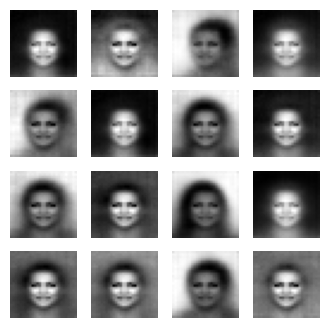

In [38]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [42]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

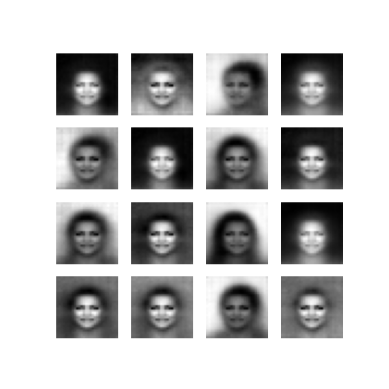

In [43]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

In [44]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\abdul\AppData\Local\Temp\ipykernel_3908\1290275450.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\abdul\AppData\Local\Temp\ipykernel_3908\1290275450.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [45]:
pip install git+https://github.com/tensorflow/docs


  Cloning https://github.com/tensorflow/docs to c:\users\abdul\appdata\local\temp\pip-req-build-y6imvo08
  Resolved https://github.com/tensorflow/docs to commit 75b2672b5bed8ca0995663536db84bd9a39b8896
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs 'C:\Users\abdul\AppData\Local\Temp\pip-req-build-y6imvo08'



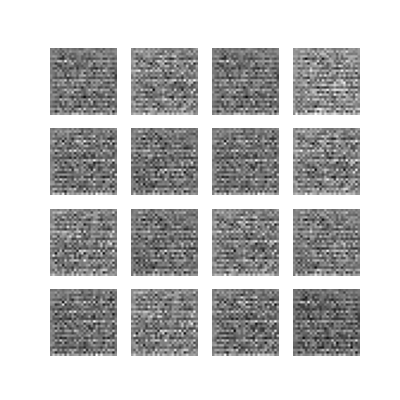

In [37]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)